<center>
<h1>The Full Machine Learning Lifecycle - How to Use Machine Learning in Production (MLOps)</h1>
<hr>
<h2>MLflow Tracking exercise - Create, track and tune your ML model</h2>
<hr>
 </center>


## Introduction
In this exercise you will create a multiclass classification model using the first batch of data available in storage. You will learn how to log metrics, parameters and tags in your MLflow run and how to inspect them in the MLflow Tracking server.

In [ ]:
import mlflow
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
)
import pickle
import sys
import os
import re
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import matplotlib.pyplot as plt

# functions needed for data pre processing
sys.path.append('/cd4ml/plugins/')
from cd4ml.data_processing import get_data, get_train_test_split, get_transformed_data


In [ ]:
# paths and variables
_raw_data_dir = '/data/batch1'

## Getting the data

In [ ]:
# get the data from blobstorage
df_raw = get_data(_raw_data_dir)

# split the data in a train and test set
df_all_train_data, _ = get_train_test_split(df_raw, n_days_test=20)

From now on we only use the train split. The test split should remain hidden for the rest of this exercise and only be used for model validation in the MLOps training pipeline.

Let's inspect the traing data:

In [ ]:
df_all_train_data.head(5)

In [ ]:
df_all_train_data.describe()

Because the test set remains hidden from this exercise, we split the training data again in a train and val set

In [ ]:
n_days_validation_set = 20

df_train, df_val = get_train_test_split(df_all_train_data, n_days_validation_set)
print('number of samples for training:', df_train.shape[0])
print('number of samples for validation:', df_val.shape[0])

# Preprocess the data (This will select the relevant features and divide the data in input (x) and labels (y))
x_train, y_train = get_transformed_data(df_train)
x_val, y_val = get_transformed_data(df_val)

## Exercise 1

The easiest way to track in MLflow in by using the autolog functionality ([see Documentation here](https://www.mlflow.org/docs/latest/python_api/mlflow.html#mlflow.autolog)). MLflow supports automatic logging of parameters, models and tags for several integrations like scikit-learn models, TensorFlow models etc. 

In the first exercise, you must:

-  <b>Set up the experiment name</b>. You should set up the experiment name with ```mlflow.set_experiment(...)``` ([see Documentation](https://www.mlflow.org/docs/latest/python_api/mlflow.html#mlflow.set_experiment)).

- <b>Implement the autologging functionality</b> to track the model ([see Documentation](https://www.mlflow.org/docs/latest/python_api/mlflow.html#mlflow.autolog))

In [ ]:
# ex 1

# SET experiment name HERE
_experiment_name = "user_1_tracking_exercise"
mlflow.set_experiment(_experiment_name)

# AUTOLOG CODE HERE
mlflow.sklearn.autolog()

with mlflow.start_run() as run:
    # print run specific info
    print(f"\nActive run_id: {run.info.run_id}")

    # set hyperparameters
    iterations = 2000
    C_value = 0.7
    
    # fit your classifier
    log_clf = LogisticRegression(C=C_value, max_iter=iterations, random_state=42)
    log_clf.fit(x_train, y_train)

As we mentioned in the slides, one of the most important capabilities of MLflow is its intuitive UI. There you can see all your logged and tracked models/artifacts, compare with other models based on decided metrics and decide on the next steps for your experimentation process. For this workshop, we have already set up an MLflow server.

<b>Go to the</b> [MLflow UI](localhost:5000) server (token: cd4ml) and familiarize yourself with it


Some of the things you should do are:

- Navigate to your experiment and see your tracked run
- See the captured metrics and hyperparameters the autologger captured from your model
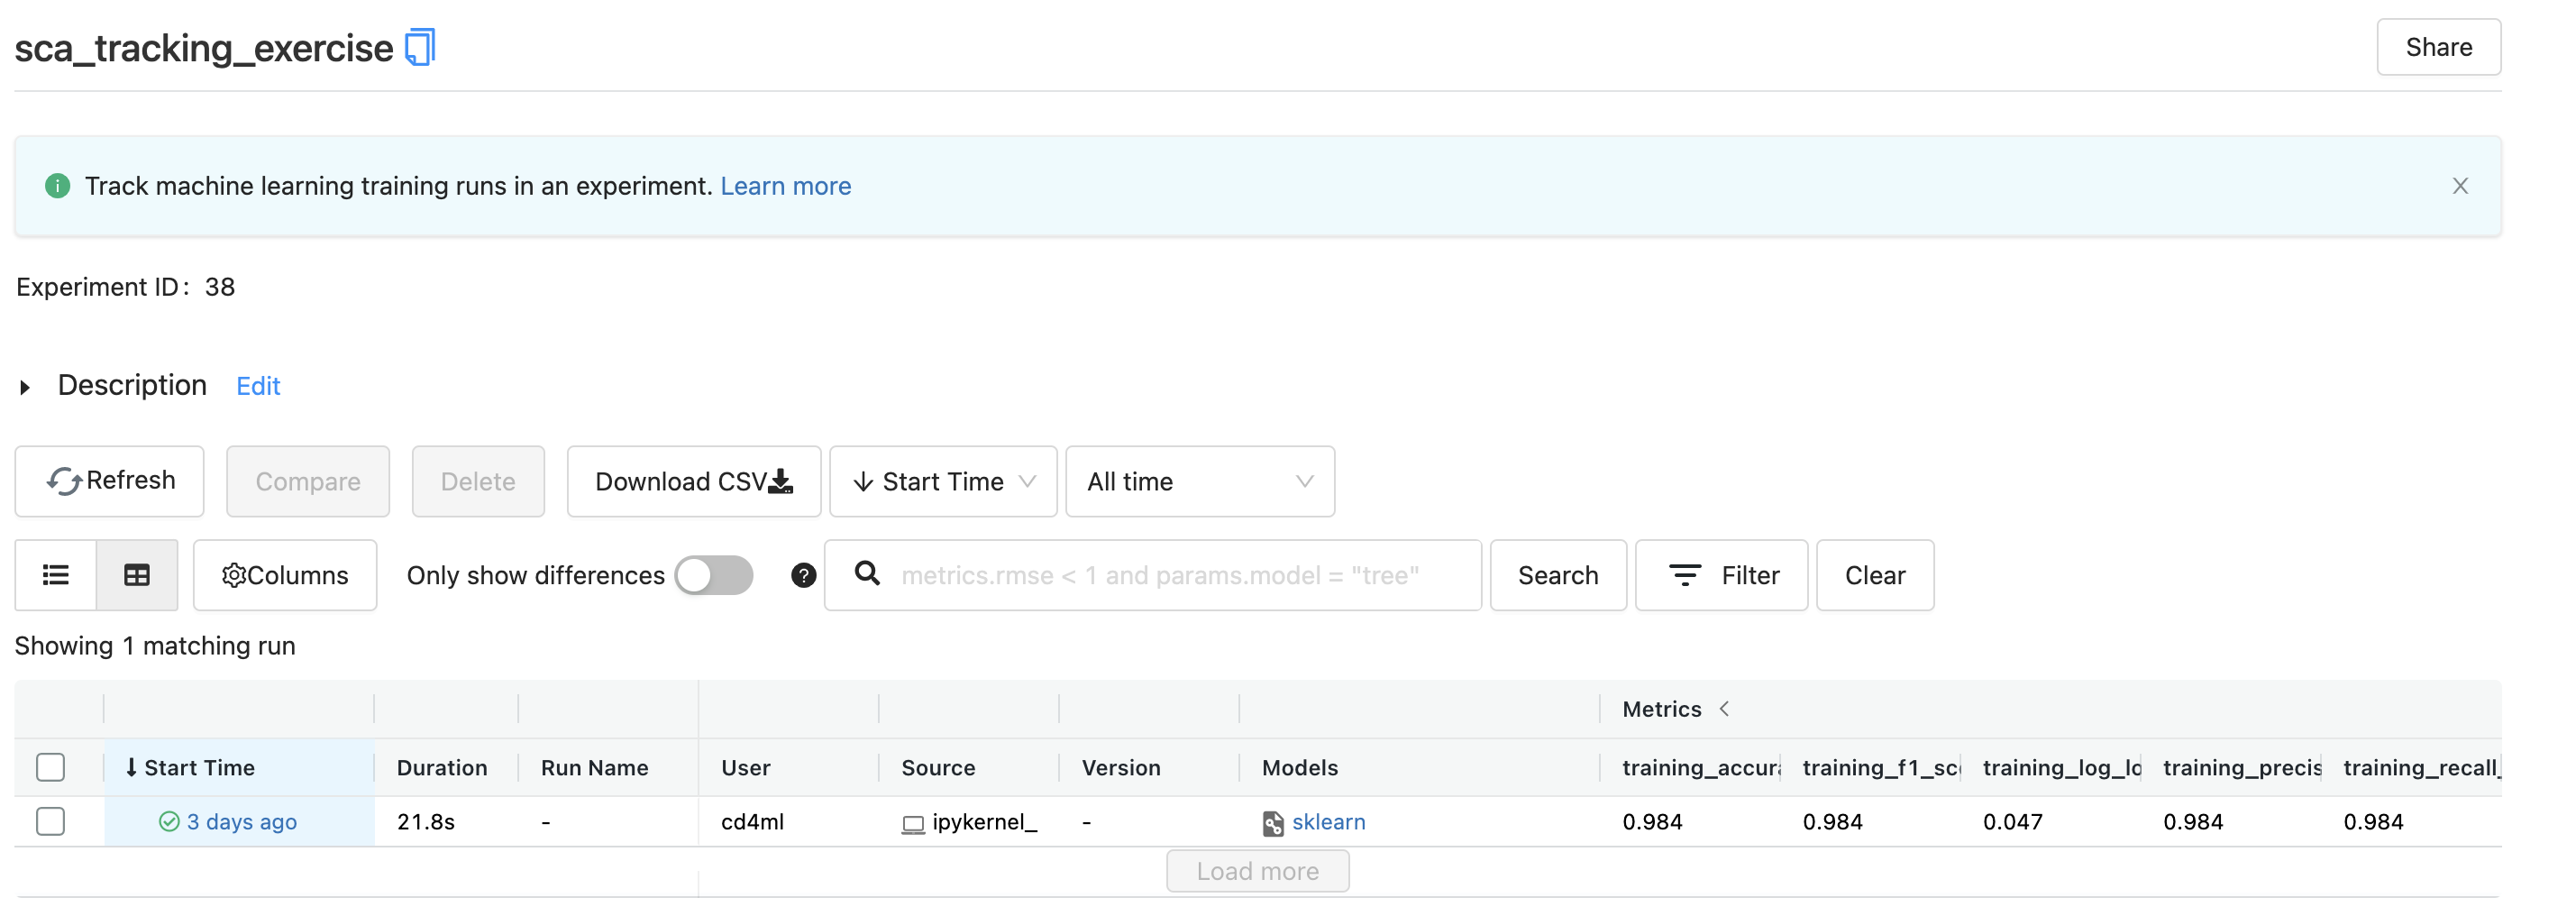



- click in the run to access the more granular information about it. Open the different tabs and familiarize yourself with all the information captured.
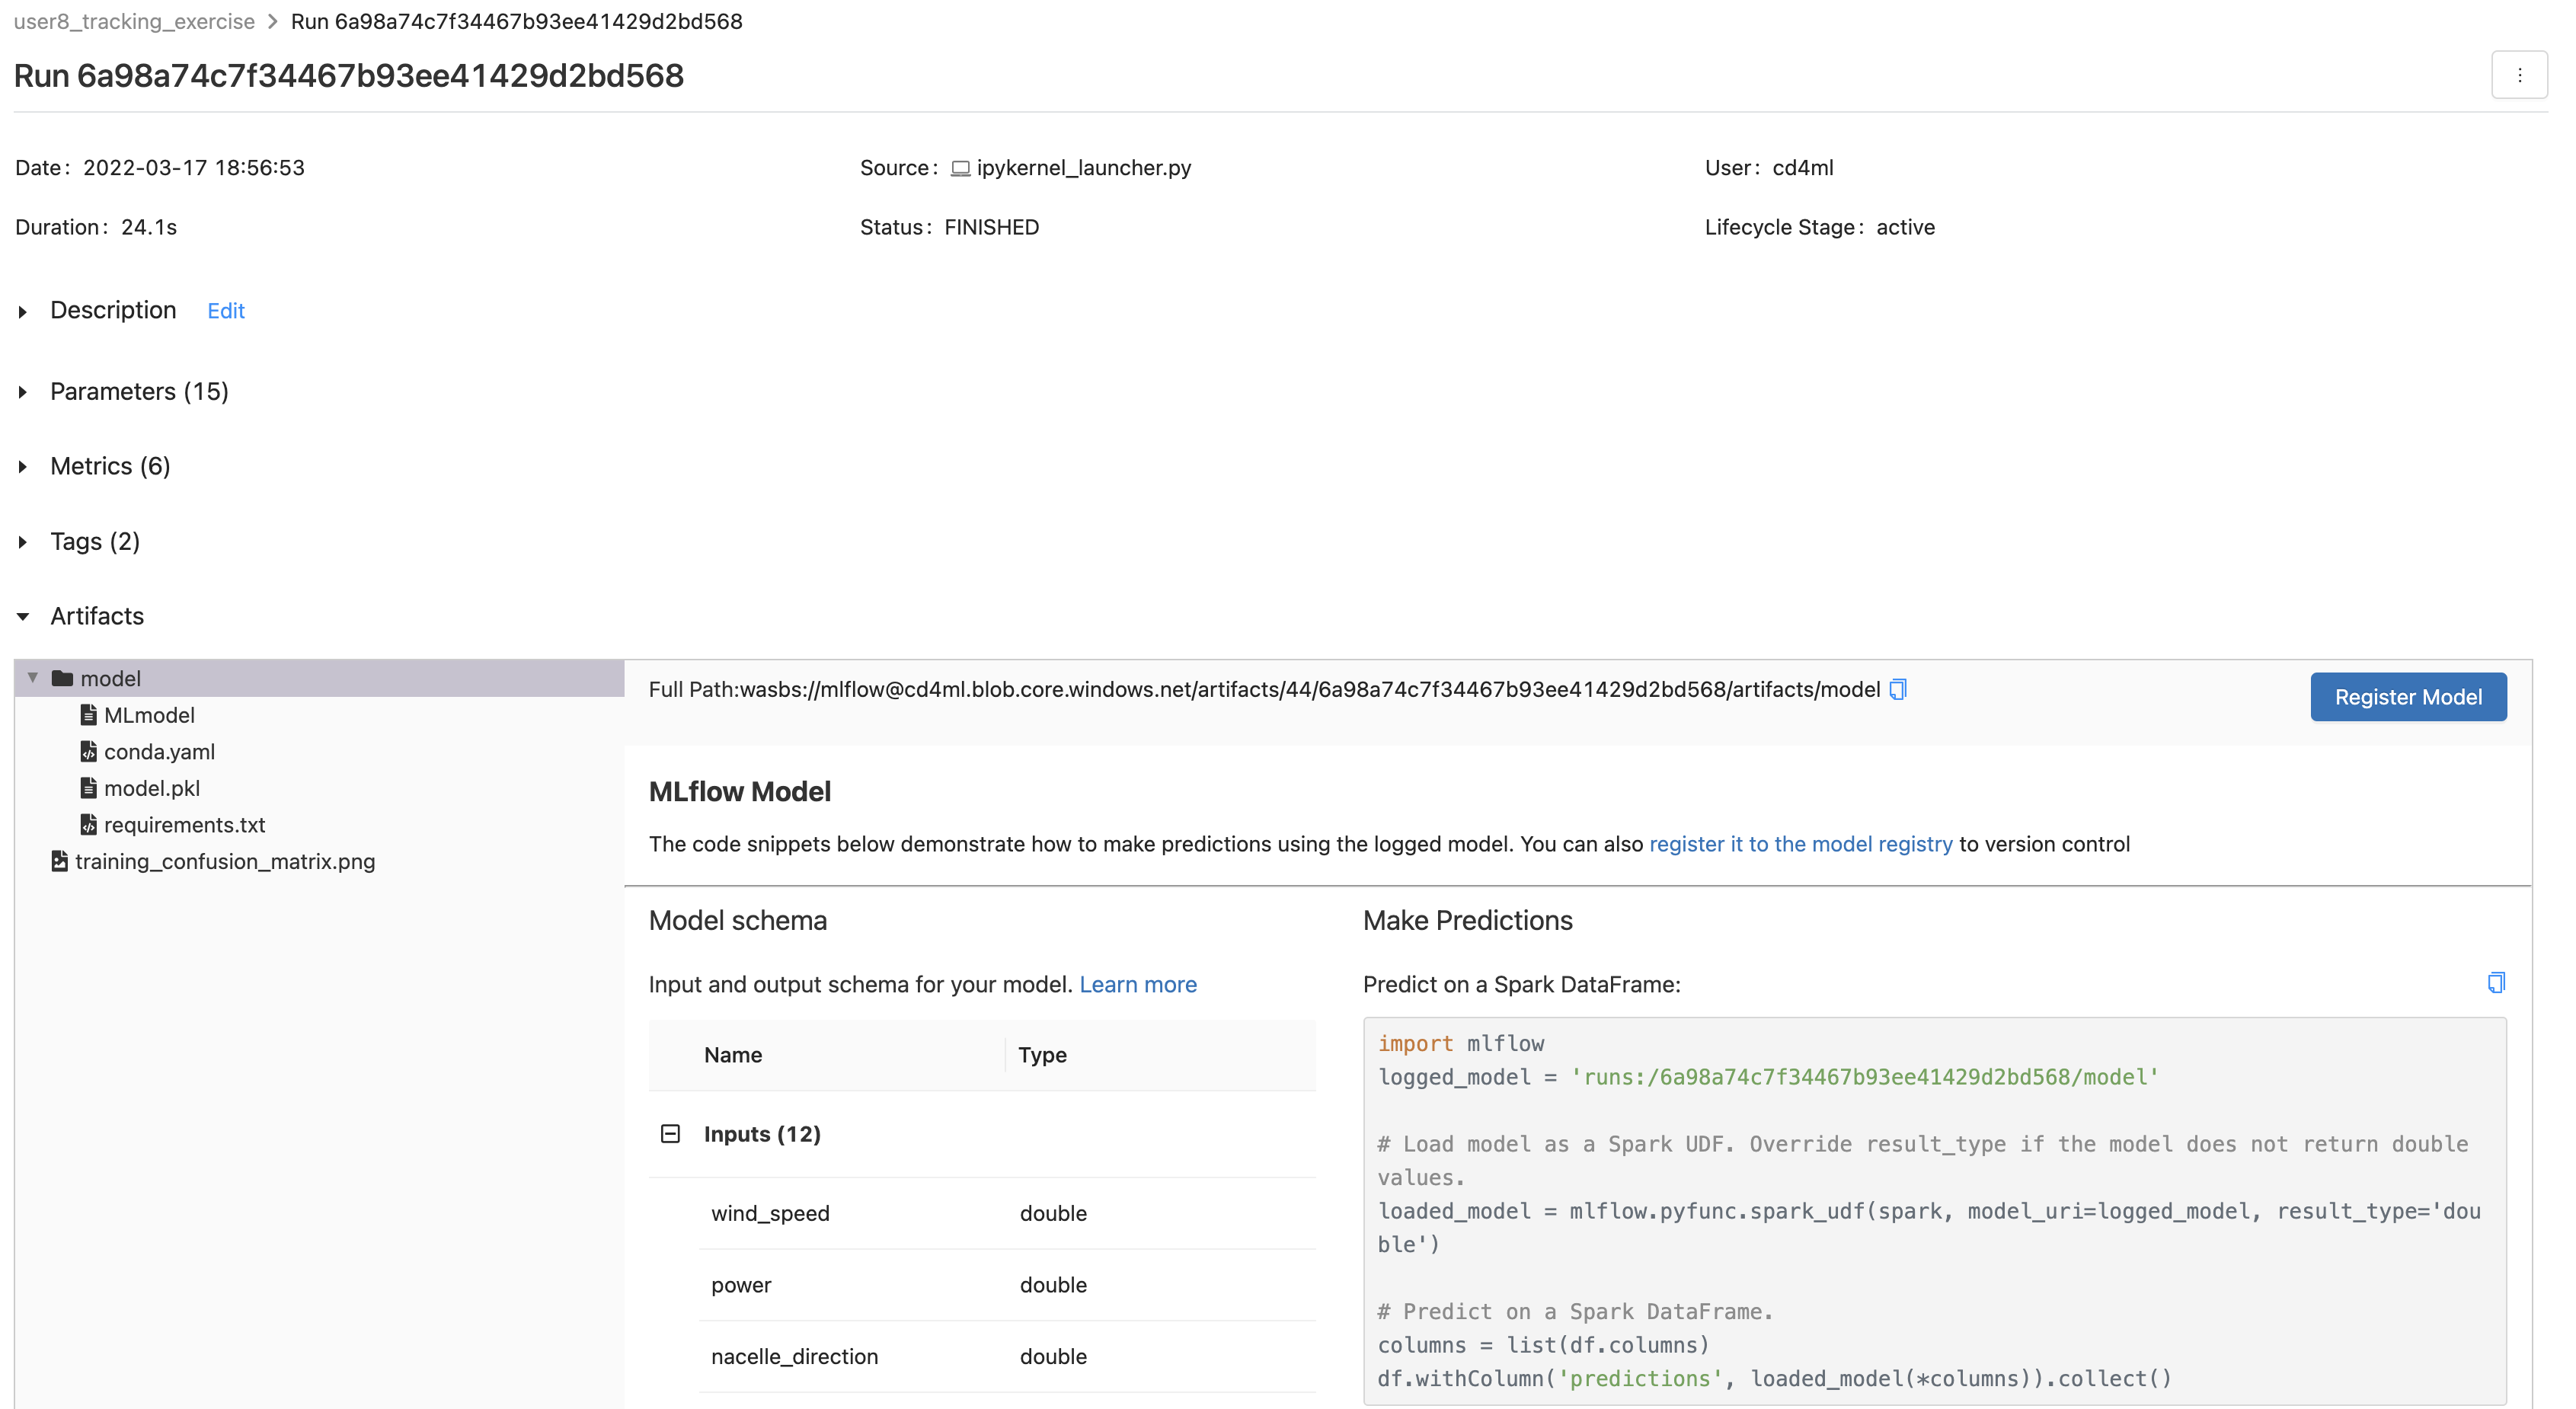

Now <b>change a hyperparameter</b> and go back to the MLflow UI to see what changed!!!


## Exercise 2

You've now logged your first model with the the autolog functionality. In this exercise, instead of using the autologger:

- <b>Log the ML model</b> using the Python API command [log_model](https://www.mlflow.org/docs/latest/python_api/mlflow.sklearn.html). Use "model" as your model name.
- <b>Log train and validation metrics</b> using the specific Python API commands from the [documentation](https://www.mlflow.org/docs/latest/python_api/mlflow.html#mlflow.log_metric). You can log some of the metrics as logged before automatically for the training data (accuracy, precision, ...) or any other metric from [sklearn-metrics](https://scikit-learn.org/stable/modules/model_evaluation.html).
- As an extra step, <u>log additional information</u> such as the split percentage of your validation set, random states and other information that you would want to know in order to replicate the results of your experiment ([documentation](https://www.mlflow.org/docs/latest/python_api/mlflow.html#mlflow.log_param)).

In [ ]:
# ex2
mlflow.sklearn.autolog(disable=True)

with mlflow.start_run() as run:
    # print run specific info
    print(f"\nActive run_id: {run.info.run_id}")

    # set hyperparameters
    iterations = 2000
    C_value = 0.7
    
    # fit your classifier
    log_clf = LogisticRegression(C=C_value, max_iter=iterations, random_state=42)
    log_clf.fit(x_train, y_train)
    
    y_train_pred = log_clf.predict(x_train) 
    # predict also on val set to log metrics
    y_val_pred = log_clf.predict(x_val)
    
    # CALCULATE YOUR METRICS HERE:
    train_accuracy = accuracy_score(y_train, y_train_pred)
    val_accuracy = accuracy_score(y_val, y_val_pred)
    # f1 = #####
    # precision = #####
    # recall = #####
    # ...
    
    # log model manually
    mlflow.sklearn.log_model(log_clf, "model")
    
    # LOG COMMANDS HERE:
    mlflow.log_metric("training_accuracy_score", train_accuracy)
    mlflow.log_metric("validation_accuracy_score", val_accuracy)
    # mlflow.log_metric(#####, f1)
    # mlflow.log_param(#####, n_days_validation_set)
    # ...

## Exercise 3

You have now tracked your model and seen how the MLflow UI displays such information a neat way. But how about registering it to the MLflow Model Registry? Go ahead and:

- <b>register your model</b> to the model registry and then 
- <b>grab</b> it from there and <b>load it back</b> for inference using MLflow's python_function (pyfunc) functionality

Useful links:
- [Logging Data to Runs](https://www.mlflow.org/docs/latest/tracking.html#logging-data-to-runs)
- [Documentation of mlflow.register_model](https://www.mlflow.org/docs/latest/python_api/mlflow.html#mlflow.register_model)
- [Model registry - Adding an MLflow Model to the Model Registry](https://www.mlflow.org/docs/latest/model-registry.html#adding-an-mlflow-model-to-the-model-registry)
- [Model registry - Fetching an MLflow Model from the Model Registry](https://www.mlflow.org/docs/latest/model-registry.html#fetching-an-mlflow-model-from-the-model-registry)
- [Documentation of mlflow.pyfunc.load_model](https://www.mlflow.org/docs/latest/python_api/mlflow.pyfunc.html#mlflow.pyfunc.load_model)

In [ ]:
# ex 3

# AUTOLOG CODE HERE
mlflow.sklearn.autolog()

with mlflow.start_run() as run:
    # print run specific info
    print(f"\nActive run_id: {run.info.run_id}")

    # fit your classifier
    iterations = 2000
    C_value = 0.7
    log_clf = LogisticRegression(C=C_value, max_iter=iterations, random_state=42)
    log_clf.fit(x_train, y_train)
    
    # REGISTER THE MODEL HERE
    model_uri = mlflow.get_artifact_uri("model") # gets the location of the model artifact of your current run
    MODEL_NAME = "user1_test"
    mv = mlflow.register_model(model_uri, MODEL_NAME)

In [ ]:
# LOAD THE LATEST MODEL AND PREDICT ON IT
my_model = mlflow.pyfunc.load_model(f"models:/{MODEL_NAME}/{mv.version}")
print(my_model.predict(x_val))

## Exercise 4

Nice work. You know now how to log, track, register and can reproduce your model if needed! Now play around, experiment and develop your own model to solve the error detection problem!

In [ ]:
# ex 4

with mlflow.start_run() as run:
    # CODE HERE
    # start
    pass
    # end

## Summary

Well done! You have learned how to:
- track experiments with the MLflow autologging functionality
- manually log you ML model and validation metrics
- register you model to, and load it from the MLflow Model registry

In the next part of our workshop we will run the end-to-end ML pipeline with Apache Airflow. Keep in mind what you learned in this exercise and inspect the models that will be created and trained in the MLflow UI